## Step 3 - LLM interaction using Hierarchical Approach

In this notebook, we will use the Hierarchical Approach to interact with the LLM model. The Hierarchical Approach is composed of two steps:
- Step 1: Generate an high-level sequence of actions to solve the task
- Step 2: From the high-level sequence of actions, generate a low-level/code-like sequence of actions

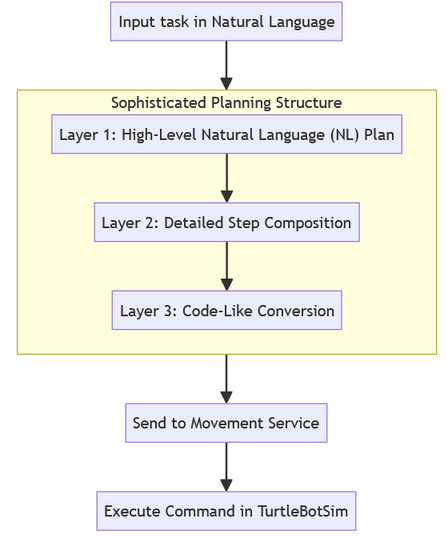

In [13]:
import pandas as pd
import os 
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm 

Layer 1 Prompt 

In [14]:
system_prompt =""" 
As an expert in robotic planning, your task is develop an plan for the robot to navigate through the environment with 2 main objectives:
1. To reach the goal 
2. To avoid collisions with obstacles/walls

The robot can do the following actions: 
- move straight (forward/backward)
- curve left/right (for example to create a circular path)
- rotate by any degree (change the orientation of the robot but not the coordinates)

The environment where the robot will navigate is {environment}.

{obstacles}



Your goal is to return a sequence of actions that the robot should take to reach the goal provided by the user while avoiding obstacles.
Each 'basic action' must have also specific details like the distance to move or the angle to rotate, the time to execute the action, etc.
Each action must consider the current position and orientation of the robot (MOST IMPORTANT CONDITION), for example the robot is oriented 
alongside Y (increasing direction) means going left x decrese, going right x increase, going forward y increase and going backward y decrese,
then rotate of 90° to the left means change the orientation along the x decreasing and so on.


{format}

{example}
"""


environment = "a 11x11 m square room, the x and y increase like in the FIRST QUADRANT fo the cartesian plane. The starting position of the robot is at the center of the room (5.5, 5.5). The robot is oriented along to the X-axis that (in this position going forward means increase the x, rotate to the LEFT means be oriented along y increasing, in front of the top wall)."
obstacles = "The room has 4 walls that surround the room."
my_format = """Return the a JSON format with a single fields: 
{
 "actions" : [list of actions]

 }
"""

example = """Example: 
User : {user_question}

Assistant : \n {actions}
"""

Layer 2 Prompt

In [15]:
layer2_prompt = """
As an expert in robotics programming, your task is to convert the high-level plan into created by the user into a sequence of actions based on the code 
constraints provided below.
Pay attention to the mathematical calculations and the constraints of the robot's movements.
An high-level command needs to be converted into a single action.

The environment where the robot will navigate is {environment}.

{obstacles}


Code constraints: 
- reasonings : the reasoning behind the conversion from high-level commands to actions.
- frontal_speed : the speed at which the robot moves forward in m/s 
- rotation : the rotational of the robot in degrees    
- time : the last of a single action in seconds

return a JSON format with all the code constraints as fields.
    
{format}

##PAY ATTENTION: 
- the rotation on the left is represented with a positive value and the rotation on the right is represented with a negative value
- to set the sign of the forward_speed you need to consider the direction of the movement of the robot (forward positive, backward negative) 
no not consider the orientation of the robot and the direction of the axes.


Examples of conversion from high-level commands to an action: 

{example}


Previous steps :

{previous_steps}

User request: {user_request}

"""

examples_conversion = """
high_level_command = "The seventh action is to move forward (along negative y-axis) 4.5  meters, so it reaches x7, y=2""
action = {"reasoning" : "move forward 4.5 meters along negative y-axis means frontal_speed = 4.5 (positive because move forward) for 1 second " , "frontal_speed": 4.5, "rotation": 0, "time": 1.0}

high_level_command = "The third action is to move forward for 2 meters (along x-axis decreasing) ."
action = {"reasoning" : "move forward 2 meters along negative x-axis means frontal_speed = 2.0 for one second " , "frontal_speed": 2.0, "rotation": 0, "time": 1.0}

high_level_command = "Than rotate 90 degrees to right."
actions = {"reasoning" : "rotation on the place means no frontal_speed, right rotation means negative degree, and -90 degree means -45 degree by 2 seconds ", "frontal_speed": 0, "rotation": -45.0, "time": 2.0}

high_level_command = "Curve left for 45 degrees."
actions = {"reasoning" : "Curve means the combination of frontal_speed and rotation, so frontal_speed of 1.0, left rotation means positive degree so 45.0 degree by 1 second","frontal_speed": 1.0, "rotation": 45.0, "time": 1.0}

high_level_command= "The second action is to rotate 90 degrees to left"
actions = {"reasoning" : "Left rotation means positive degree, to rotate 90 degree i need 45° by 2 seconds","frontal_speed": 0, "rotation": 45.0, "time": 2.0}

high_level_command = "The last action is to move forward for 10 meters (along y-axis increasing) ."
action = {"reasoning" : "move forward 10 meters (along y-axis increasing) means frontal_speed = 5.0 (the orientation is not useful) for 2 seconds " , "frontal_speed": 5.0, "rotation": 0, "time": 2.0}
"""



own_format = """
    {
"action" : action,
    }
"""

In [16]:
from openai import OpenAI, AzureOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from pprint import pprint
import ast
import os 
from dotenv import load_dotenv
load_dotenv('.env.local')



def gpt_chat_completion(messages : list[dict], temperature: float = 0.0, frequency_penalty: float = 0.0 , max_tokens: int = None): 
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY") )
    completion = client.chat.completions.create(
        model=os.getenv("OPENAI_MODEL"),
        messages=messages,
        temperature=temperature,
        seed = 42,
        frequency_penalty = frequency_penalty,
        #max_tokens=max_tokens,
        )
    return completion.choices[0].message.content


def gpt_chat_completion_azure(messages : list[dict], temperature: float = 0.0, frequency_penalty: float = 0.0 , max_tokens: int = None): 
    client = AzureOpenAI(api_key = os.getenv("AZURE_OPENAI_KEY"),  
    api_version = os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),)
    completion = client.chat.completions.create(
        

        model="gpt-4-turbo",
        messages=messages,
        temperature=temperature,
        seed = 42,
        frequency_penalty = frequency_penalty,
        #max_tokens=max_tokens,
        )
    return completion.choices[0].message.content

def get_embedding(text, model="large"):
    if model == 'large' : 
      emb_model = "text-embedding-3-large"
    elif model == 'small' :
        emb_model = "text-embedding-3-small"
    else: 
        emb_model = "text-embedding-ada-002"
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY") )
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=emb_model).data[0].embedding


def claude_completion(messages : list[tuple], model='claude-3-opus-20240229') : 
    llm = ChatAnthropic(model=model,
                    temperature=0,
                    max_tokens=1024,
                    api_key=os.getenv("ANTHROPIC_API_KEY"),
                    
                    )
    prompt = ChatPromptTemplate.from_messages(
        messages=messages
    )

    chain = prompt | llm
    msg = chain.invoke(messages)
    
    return msg.content

#### Retrieve nearest questions 

This function retrieves the nearest questions from a set of examples (created by me) to provide the best possible examples to the model. The idea is to find a similar question to the one we want to ask the model, based on the conversion of the question into a vector representation and calculating the euclidean distance between the vectors.
This techinique can be useful when the dataset will be bigger and we want to find a previous example that can be useful to solve the current problem.

In [17]:
def retrive_nearest_question(user_question):
    df : pd.DataFrame = pd.read_pickle(os.path.join("data", "examples.pkl"))
    user_question_embedding = get_embedding(user_question, "ada")
    df = pd.read_pickle(os.path.join("data", "examples.pkl"))
    df["distance"] = df.embedding_question.apply(lambda x : euclidean_distances([user_question_embedding], [x])[0][0])
    return df.sort_values("distance").iloc[0]

In [18]:
questions = ["The robot must create a square path of side 2 m" ,"The robot must creare a circlular path", "The robot must create rectangle of dimension width = 3 and heigh = 1"  ,"The robot must creare an equilateral triangle", " The robot must reach x = 2.5 and y= 9.0" ]
# retrieved_example = [retrive_nearest_question(q) for q in questions]
# df = pd.DataFrame(retrieved_example)
# df.to_pickle(os.path.join("data", "retrieved_example.pkl"))
df = pd.read_pickle(os.path.join("data", "retrieved_example.pkl"))

In [20]:
retrieved_examples = df.to_dict(orient="records")
len(retrieved_examples)

5

In [ ]:
import logging
results = list()

# for index in range(3):
#   results = list()
for question, example_template in zip(questions,retrieved_examples) : 
    ex = example.format(actions = str(example_template['actions']) , user_question = example_template['user_question'])
    fist_layer = system_prompt.format(environment=environment, obstacles=obstacles, format=my_format, example=ex)
    messages=[
    {"role": "system", "content": fist_layer},
    {"role": "user", "content": question}
        ]
    #high_level_plan = llama_chat_completion(messages, temperature=0.0, frequency_penalty=0.0)
    logging.info("High level plan completed")
    high_level_plan = gpt_chat_completion(messages, temperature=0.0, frequency_penalty=0.0)
    json_plan = high_level_plan[ high_level_plan.find("{"): high_level_plan.rfind("}")+1]
    steps = list()
    for single_step in tqdm(ast.literal_eval(json_plan)['actions']) : 
        second_layer = layer2_prompt.format( example=examples_conversion, format=own_format, environment = environment,obstacles=obstacles, previous_steps = steps, user_request = question ).strip()

        count = 0
        while count < 50:
            count+=1
            try:
                step = gpt_chat_completion([{'role': 'system', 'content': second_layer}, {'role': 'user', 'content': "high_level_commands =" + single_step}])
                json_action = step[ step.find("{"): step.rfind("}")+1]
                json_action = ast.literal_eval(json_action)
                json_action = json_action.get('action', None) if 'action' in json_action.keys() else json_action 
                if 'frontal_speed' not in json_action.keys() or  'rotation' not in json_action.keys() or 'time' not in json_action.keys() : 
                    print('###Eccezioneee')
                    raise Exception
                steps.append(json_action)
                #print(json_action)
                break
            except:
                continue
    results.append({"question" : question , "high_level_plan" : json_plan , "steps" :steps })
    print(f"Low level plan for question :  {question} !! COMPLETED")


In [ ]:
df = pd.DataFrame(results)
df.to_excel(f"tmp_v0_allsteps.xlsx", index=False)